In [1]:
import os
import re
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon

import shapely

import clima_anom as ca

import matplotlib.cbook
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

In [2]:
andes = list(shpreader.Reader('..'+os.sep+'mapping'+os.sep+'andes_1000.shp').geometries())

In [3]:
#Using IMERG 05x05 grid
file_in = '/mnt/Data/Data/IMERG/season/summer/IMERG_2000_12_2020_12_24h_05x05_summer.nc'
# file_in = 'E:'+os.sep+'Data'+os.sep+'IMERG'+os.sep+'season'+os.sep+'summer'+os.sep+'IMERG_2001_01_2020_12_24h_05x05_summer.nc'

data = ca.read_netcdf(file_in,0)
lat = data['lat'].data
lon = data['lon'].data

lon2d, lat2d = np.meshgrid(lon, lat)

nlat = len(lat)
nlon = len(lon)

res_y = lat[1]-lat[0]
res_x = lon[1]-lon[0]

del data

print(f'Latitude points   : {nlat}')
print(f'Longitude points  : {nlon}')
print(f'Spatial resolution: {res_x}x{res_y}')

Latitude points   : 120
Longitude points  : 110
Spatial resolution: 0.5x0.5


In [4]:
xmin, ymin, xmax, ymax= np.min(lon2d)-0.25,np.min(lat2d)+0.25,np.max(lon2d)-0.25,np.max(lat2d)+0.25

# how many cells across and down
cell_size_y=0.5
cell_size_x=0.5

# projection of the grid
crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size_x, cell_size_x ):
    for y0 in np.arange(ymin, ymax+cell_size_y, cell_size_y):
        # bounds
        x1 = x0+cell_size_x
        y1 = y0-cell_size_y
        grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )

cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs="EPSG:4326")
cell = cell.reset_index()

In [5]:
product = 'kurpf'

In [6]:
path_in = os.sep+'mnt'+os.sep+'Data'+os.sep+'Data'+os.sep+'PF'+os.sep+product+'_SA'+os.sep+product+'_*.csv'
file_list = glob.glob(path_in)
file_list = sorted(file_list)
len_files = len(file_list)
print(f'Files Number: {len_files}')

Files Number: 85


In [7]:
print(file_list[0])
print(file_list[-1])

/mnt/Data/Data/PF/kurpf_SA/kurpf_201403_level2.csv
/mnt/Data/Data/PF/kurpf_SA/kurpf_202103_level2.csv


In [8]:
# Show columns
data_tmp = pd.read_csv(file_list[0])
data_tmp.head(2)

,lat,lon,YEAR,ORBIT,NPIXELS_20DBZ,NPIXELS_30DBZ,NPIXELS_40DBZ,NPIXELS_50DBZ,NPIXELS_20MM,NPIXELS_30MM,...,MIN85PCT,NLT250,NLT225,N37LT250,N37LT225,MAXHT20,MAXHT30,MAXHT40,NSTRAT_KU,NCONV_KU
0,14.503548,-47.985703,2014.0,148.0,2.0,0.0,0.0,0.0,0.0,0.0,...,283.450012,0.0,0.0,0.0,0.0,2.25,0.0,0.0,0.0,3.0
1,14.930592,-47.027515,2014.0,148.0,3.0,1.0,0.0,0.0,0.0,0.0,...,283.309998,0.0,0.0,0.0,0.0,2.38,2.0,0.0,0.0,3.0


In [9]:
# var = 'NPIXELS_40DBZ'
# var_name = '40dbz_GT_10km'

# var = 'NPIXELS_20DBZ'
# var_name = '20dbz_GT_10km'

# var = 'MAXHT40'
# var_name = 'MAXHT40_GT_10km'

# var = 'MAXHT20'
# var_name = 'MAXHT20_GT_10km'

var = 'NPIXELS_20MM'
var_name = 'NPIXELS_GT_20MM'

# var = 'NPIXELS_30MM'
# var_name = 'NPIXELS_GT_30MM'

# var = 'NCONV_KU'
# var_name = 'NCONV'

# var = 'MIN85PCT'
# var_name = 'MIN85PCT_LT_225K'

In [10]:
# WORKS!!

# data = pd.read_csv(file_list[0])
# data_cut = data[data[var]!=0]

# PF_GPD = gpd.GeoDataFrame(data=data_cut[var],geometry=gpd.points_from_xy(data_cut['lon'],data_cut['lat'], crs="EPSG:4326"))

# wells_cell = gpd.sjoin(PF_GPD, cell, how = "inner", predicate = "intersects")
# test = wells_cell.groupby(['index_right'], as_index=False).mean()

# bay_area_grid = cell.merge(test, on = 'index', how = "left")
# bay_area_grid[var] = bay_area_grid[var].fillna(0)
# # bay_area_grid[var] = bay_area_grid[var].astype(int)

# data_out = bay_area_grid[var].values.reshape(nlon, nlat).T

In [37]:
pf_count = np.zeros([len_files,nlat,nlon])

print(f'variable: {var}')

for t in range(len_files):

    file_in = file_list[t]
    name_out = file_in.split('/')[-1]
    print(name_out)

    data = pd.read_csv(file_in)
    # data_cut = data[(data['NPIXELS_30MM']!=0)&(data[var]<225)]
    data_cut = data[data[var]!=0]

    PF_GPD = gpd.GeoDataFrame(data=data_cut[var],geometry=gpd.points_from_xy(data_cut['lon'],data_cut['lat'], crs="EPSG:4326"))

    wells_cell = gpd.sjoin(PF_GPD, cell, how = "inner", predicate = "intersects")
    test = wells_cell.groupby(['index_right'], as_index=False).mean()

    bay_area_grid = cell.merge(test, on = 'index', how = "left")
    # bay_area_grid[var] = bay_area_grid[var].fillna(0)

    data_out = bay_area_grid[var].values.reshape(nlon, nlat).T

    pf_count[t,:,:] = data_out

variable: NCONV_KU
kurpf_201403_level2.csv
kurpf_201404_level2.csv
kurpf_201405_level2.csv
kurpf_201406_level2.csv
kurpf_201407_level2.csv
kurpf_201408_level2.csv
kurpf_201409_level2.csv
kurpf_201410_level2.csv
kurpf_201411_level2.csv
kurpf_201412_level2.csv
kurpf_201501_level2.csv
kurpf_201502_level2.csv
kurpf_201503_level2.csv
kurpf_201504_level2.csv
kurpf_201505_level2.csv
kurpf_201506_level2.csv
kurpf_201507_level2.csv
kurpf_201508_level2.csv
kurpf_201509_level2.csv
kurpf_201510_level2.csv
kurpf_201511_level2.csv
kurpf_201512_level2.csv
kurpf_201601_level2.csv
kurpf_201602_level2.csv
kurpf_201603_level2.csv
kurpf_201604_level2.csv
kurpf_201605_level2.csv
kurpf_201606_level2.csv
kurpf_201607_level2.csv
kurpf_201608_level2.csv
kurpf_201609_level2.csv
kurpf_201610_level2.csv
kurpf_201611_level2.csv
kurpf_201612_level2.csv
kurpf_201701_level2.csv
kurpf_201702_level2.csv
kurpf_201703_level2.csv
kurpf_201704_level2.csv
kurpf_201705_level2.csv
kurpf_201706_level2.csv
kurpf_201707_level2.c

In [ ]:
linewidth_limit = 0.5

# cmap reds
cmap = plt.get_cmap('hot_r')

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(8,8),dpi=200)
gs = gridspec.GridSpec(1,2)

#=====================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.coastlines(linestyle='-',linewidth=0.1,color='black',zorder=4)
ax1.add_geometries(andes,proj,edgecolor='k',facecolor='None',linestyle='-',linewidth=0.1,zorder=5)
ax1.set_extent([-90,-25,-45,15])

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

# a1 = ax1.scatter(data_cut['lon'],data_cut['lat'],s=data_cut[var]/data_cut[var].max(),c=data_cut[var],alpha=1,vmin=1,vmax=22,cmap=cmap)
a1 = ax1.contourf(lon2d, lat2d, np.nanmean(pf_count,axis=0),levels=None,cmap=cmap)
plt.colorbar(a1,fraction=0.05,ticks=None)

ax1.set_title(var,fontsize=8,loc='left')
ax1.set_title('mean',fontsize=8,loc='right')

#=====================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.coastlines(linestyle='-',linewidth=0.1,color='black',zorder=4)
ax1.add_geometries(andes,proj,edgecolor='k',facecolor='None',linestyle='-',linewidth=0.1,zorder=5)
ax1.set_extent([-90,-25,-45,15])

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

a1 = ax1.contourf(lon2d, lat2d, np.nanmax(pf_count,axis=0),levels=None,cmap=cmap)
plt.colorbar(a1,fraction=0.05,ticks=None)

ax1.set_title('max',fontsize=8,loc='right')

/tmp/ipykernel_86933/609247477.py:26: RuntimeWarning: Mean of empty slice
  a1 = ax1.contourf(lon2d, lat2d, np.nanmean(pf_count,axis=0),levels=None,cmap=cmap)
/tmp/ipykernel_86933/609247477.py:46: RuntimeWarning: All-NaN slice encountered
  a1 = ax1.contourf(lon2d, lat2d, np.nanmax(pf_count,axis=0),levels=None,cmap=cmap)


Text(1.0, 1.0, 'max')

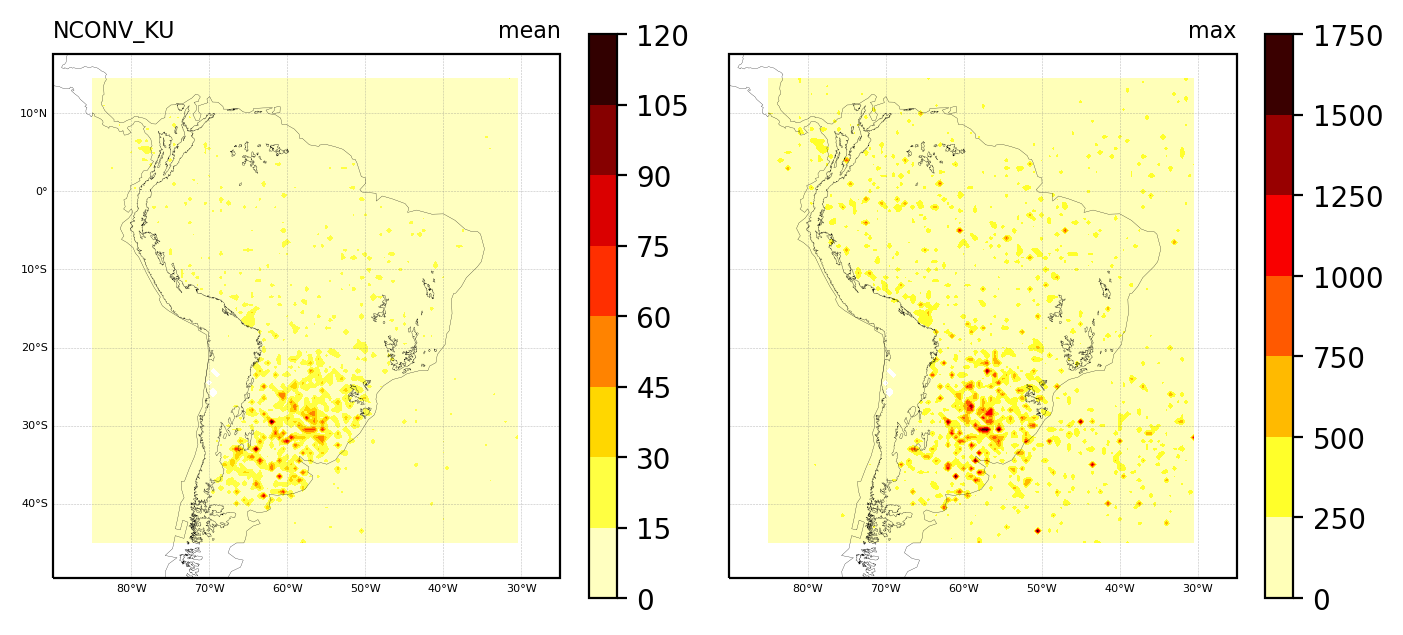

In [38]:
linewidth_limit = 0.5

# cmap reds
cmap = plt.get_cmap('hot_r')

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(8,8),dpi=200)
gs = gridspec.GridSpec(1,2)

#=====================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.coastlines(linestyle='-',linewidth=0.1,color='black',zorder=4)
ax1.add_geometries(andes,proj,edgecolor='k',facecolor='None',linestyle='-',linewidth=0.1,zorder=5)
ax1.set_extent([-90,-25,-45,15])

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

# a1 = ax1.scatter(data_cut['lon'],data_cut['lat'],s=data_cut[var]/data_cut[var].max(),c=data_cut[var],alpha=1,vmin=1,vmax=22,cmap=cmap)
a1 = ax1.contourf(lon2d, lat2d, np.nanmean(pf_count,axis=0),levels=None,cmap=cmap)
plt.colorbar(a1,fraction=0.05,ticks=None)

ax1.set_title(var,fontsize=8,loc='left')
ax1.set_title('mean',fontsize=8,loc='right')

#=====================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.coastlines(linestyle='-',linewidth=0.1,color='black',zorder=4)
ax1.add_geometries(andes,proj,edgecolor='k',facecolor='None',linestyle='-',linewidth=0.1,zorder=5)
ax1.set_extent([-90,-25,-45,15])

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

a1 = ax1.contourf(lon2d, lat2d, np.nanmax(pf_count,axis=0),levels=None,cmap=cmap)
plt.colorbar(a1,fraction=0.05,ticks=None)

ax1.set_title('max',fontsize=8,loc='right')

/tmp/ipykernel_86933/1148547058.py:26: RuntimeWarning: Mean of empty slice
  a1 = ax1.contourf(lon2d, lat2d, np.nanmean(pf_count,axis=0),levels=None,cmap=cmap)
/tmp/ipykernel_86933/1148547058.py:46: RuntimeWarning: All-NaN slice encountered
  a1 = ax1.contourf(lon2d, lat2d, np.nanmin(pf_count,axis=0),levels=None,cmap=cmap)


Text(1.0, 1.0, 'min')

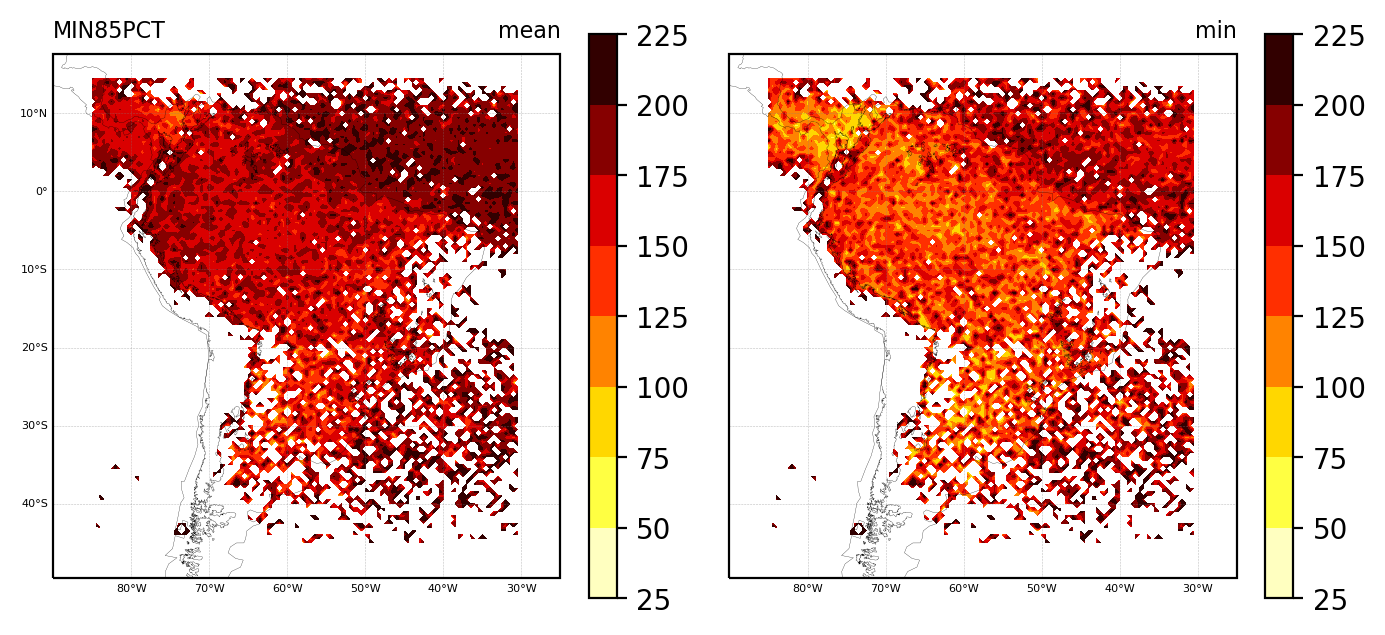

In [30]:
linewidth_limit = 0.5

# cmap reds
cmap = plt.get_cmap('hot_r')

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(8,8),dpi=200)
gs = gridspec.GridSpec(1,2)

#=====================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.coastlines(linestyle='-',linewidth=0.1,color='black',zorder=4)
ax1.add_geometries(andes,proj,edgecolor='k',facecolor='None',linestyle='-',linewidth=0.1,zorder=5)
ax1.set_extent([-90,-25,-45,15])

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

# a1 = ax1.scatter(data_cut['lon'],data_cut['lat'],s=data_cut[var]/data_cut[var].max(),c=data_cut[var],alpha=1,vmin=1,vmax=22,cmap=cmap)
a1 = ax1.contourf(lon2d, lat2d, np.nanmean(pf_count,axis=0),levels=None,cmap=cmap)
plt.colorbar(a1,fraction=0.05,ticks=None)

ax1.set_title(var,fontsize=8,loc='left')
ax1.set_title('mean',fontsize=8,loc='right')

#=====================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.coastlines(linestyle='-',linewidth=0.1,color='black',zorder=4)
ax1.add_geometries(andes,proj,edgecolor='k',facecolor='None',linestyle='-',linewidth=0.1,zorder=5)
ax1.set_extent([-90,-25,-45,15])

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

a1 = ax1.contourf(lon2d, lat2d, np.nanmin(pf_count,axis=0),levels=None,cmap=cmap)
plt.colorbar(a1,fraction=0.05,ticks=None)

ax1.set_title('min',fontsize=8,loc='right')

Text(1.0, 1.0, 'max')

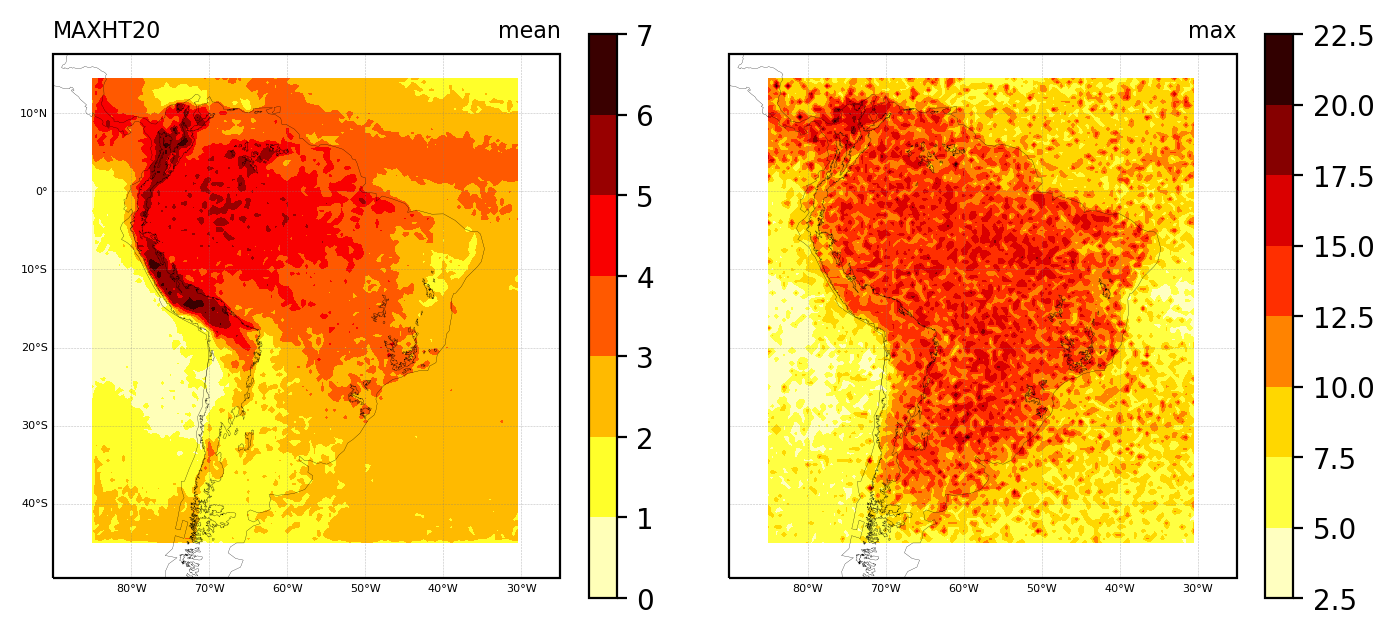

In [58]:
linewidth_limit = 0.5

# cmap reds
cmap = plt.get_cmap('hot_r')

levels = np.arange(1,23,1)
ticks = np.arange(1,23,2)

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(8,8),dpi=200)
gs = gridspec.GridSpec(1,2)

#=====================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.coastlines(linestyle='-',linewidth=0.1,color='black',zorder=4)
ax1.add_geometries(andes,proj,edgecolor='k',facecolor='None',linestyle='-',linewidth=0.1,zorder=5)
ax1.set_extent([-90,-25,-45,15])

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

# a1 = ax1.scatter(data_cut['lon'],data_cut['lat'],s=data_cut[var]/data_cut[var].max(),c=data_cut[var],alpha=1,vmin=1,vmax=22,cmap=cmap)
a1 = ax1.contourf(lon2d, lat2d, np.mean(pf_count,axis=0),levels=None,cmap=cmap)
plt.colorbar(a1,fraction=0.05,ticks=None)

ax1.set_title(var,fontsize=8,loc='left')
ax1.set_title('mean',fontsize=8,loc='right')

#=====================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.coastlines(linestyle='-',linewidth=0.1,color='black',zorder=4)
ax1.add_geometries(andes,proj,edgecolor='k',facecolor='None',linestyle='-',linewidth=0.1,zorder=5)
ax1.set_extent([-90,-25,-45,15])

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

a1 = ax1.contourf(lon2d, lat2d, np.max(pf_count,axis=0),levels=None,cmap=cmap)
plt.colorbar(a1,fraction=0.05,ticks=None)

ax1.set_title('max',fontsize=8,loc='right')

Text(1.0, 1.0, 'max')

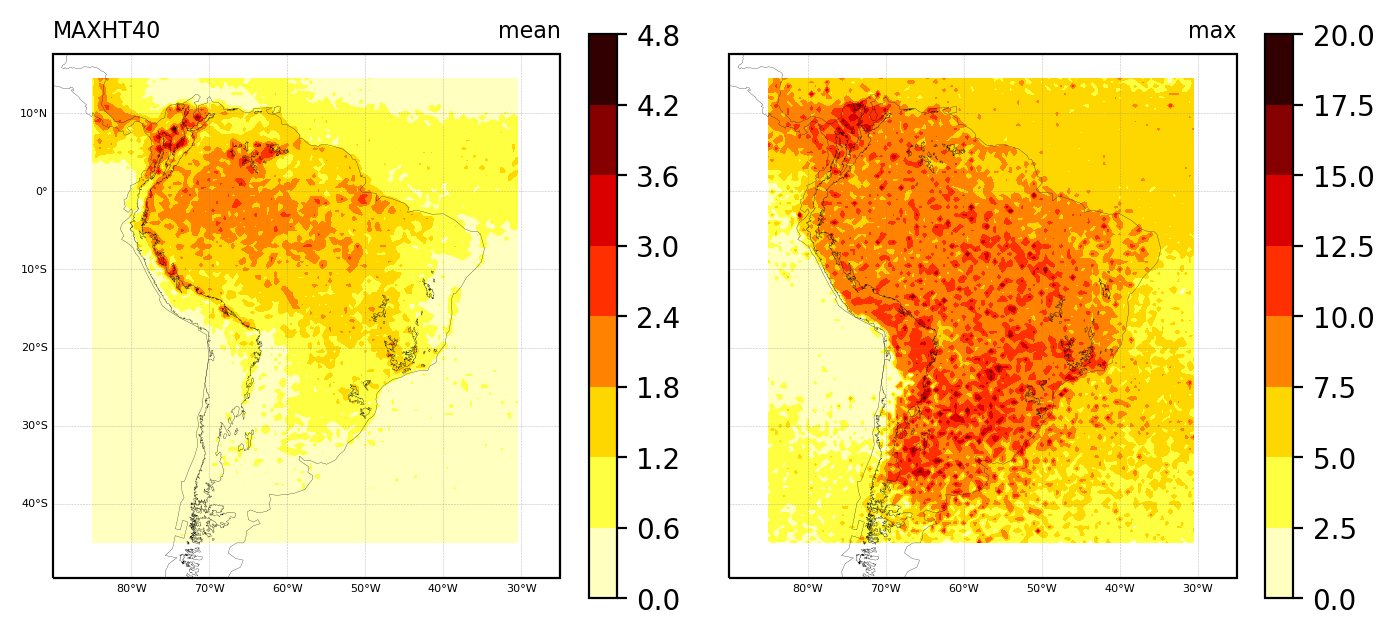

In [54]:
linewidth_limit = 0.5

# cmap reds
cmap = plt.get_cmap('hot_r')

levels = np.arange(1,23,1)
ticks = np.arange(1,23,2)

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(8,8),dpi=200)
gs = gridspec.GridSpec(1,2)

#=====================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.coastlines(linestyle='-',linewidth=0.1,color='black',zorder=4)
ax1.add_geometries(andes,proj,edgecolor='k',facecolor='None',linestyle='-',linewidth=0.1,zorder=5)
ax1.set_extent([-90,-25,-45,15])

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

# a1 = ax1.scatter(data_cut['lon'],data_cut['lat'],s=data_cut[var]/data_cut[var].max(),c=data_cut[var],alpha=1,vmin=1,vmax=22,cmap=cmap)
a1 = ax1.contourf(lon2d, lat2d, np.mean(pf_count,axis=0),levels=None,cmap=cmap)
plt.colorbar(a1,fraction=0.05,ticks=None)

ax1.set_title(var,fontsize=8,loc='left')
ax1.set_title('mean',fontsize=8,loc='right')

#=====================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.coastlines(linestyle='-',linewidth=0.1,color='black',zorder=4)
ax1.add_geometries(andes,proj,edgecolor='k',facecolor='None',linestyle='-',linewidth=0.1,zorder=5)
ax1.set_extent([-90,-25,-45,15])

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

a1 = ax1.contourf(lon2d, lat2d, np.max(pf_count,axis=0),levels=None,cmap=cmap)
plt.colorbar(a1,fraction=0.05,ticks=None)

ax1.set_title('max',fontsize=8,loc='right')